## What we know about our analytical model of the homeless response system

In [1]:
import ranking_and_selection as rs
import queueing_model as qm
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Opening JSON file
with open('data_as_is.json') as json_file:
    data_as_is = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_simulation.json') as json_file:
    data_as_is_simulation = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_analytical.json') as json_file:
    data_as_is_analytical = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_exp2.json') as json_file:
    data_as_is_exp2 = json.load(json_file)

In [3]:
# Baseline build rate
sol = [{'housing': [12, 12, 12, 12], 'shelter': [12, 12, 12, 12]}]

This discussion is based on a simple experiment (using the analytical queueing model of the homeless response system) where we start with specific values of: 

* the initial number of people in the system,
* the initial capacity of accommodation (housing and shelter),
* a constant arrival rate function,
* a baseline number of extra capacity (housing and shelter units) to build every year.

We choose these specific values to ensure that during the course of our model runs, the average service rate (of customers in housing units) is roughly equivalent to the arrival rate, given that we will adding extra accommodation above the baseline (as discussed shortly).

In [4]:
print('Initial number in system: ' + str(data_as_is_exp2['initial_demand']))
print('Initial capacity: ' + str(data_as_is_exp2['initial_capacity']))
print('Arrival rate in each year: ' + str(data_as_is_exp2['arrival_rates'][0]))
print('Baseline extra housing units to build per year: ' + str(sol[0]['housing'][0]))
print('Baseline extra shelter units to build per year: ' + str(sol[0]['shelter'][0]))

Initial number in system: 180
Initial capacity: {'housing': 40, 'shelter': 15}
Arrival rate in each year: 100
Baseline extra housing units to build per year: 12
Baseline extra shelter units to build per year: 12


We then allow an extra budget (worth 60 housing units) to be spent in one year only, either for building 60 extra housing units in that year or for building the amount of extra shelter units which can be afforded with this budget (the number of which depends on the cost of shelter compared to housing). This extra capacity is over and above the baseline 12 units or housing and shelter to be built each year regardless. 

We then explore how our objective value changes depending on which year we decide to build that extra capacity, and on whether we decide to use that extra budget on extra housing or on extra shelter. Our objective value is simply the time average of the expected value of the size of the unsheltered queue over the course of the model run. 

For example, we first run our model for 10 years and allow our extra budget to be spent in one of the first four years. We assume that the service rate at each housing unit is 0.5 and that the cost of shelter is the same as the cost of housing. The latter means that if we decide to spend our extra budget on housing, we can build 60 units, and if we decide on shelter, we also get 60 units. 

In Figure 1 below we plot the objective value (covering the whole period of the model run) as a function of the year in which we have decided to spend our budget. There are eight possible solutions, spending our extra budget on housing or on shelter in one of the first four years of the model run, and the points illustrate the objective values of those solutions, as given by the analytical queueing model.

In [5]:
# print('start at time ' + str(datetime.datetime.now()))
b = 12 # baseline number of housing to build each yr
s = 12 # baseline number of shelter to build each yr
hx = 60 # base amount of extra accomm
additional_shelter = [hx]
service_times = [2]
yrs_dec = 4

housing_imprv_all1_obj1 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all1_obj1 = [[] for i in range(len(additional_shelter))]

for i in range(len(additional_shelter)):
    sx = additional_shelter[i]
    for j in range(len(service_times)):
        sols = [{'housing': [12+hx, 12, 12, 12], 'shelter': [12, 12, 12, 12]},
                {'housing': [12, 12+hx, 12, 12], 'shelter': [12, 12, 12, 12]},
                {'housing': [12, 12, 12+hx, 12], 'shelter': [12, 12, 12, 12]},
                {'housing': [12, 12, 12, 12+hx], 'shelter': [12, 12, 12, 12]},
                {'housing': [12, 12, 12, 12], 'shelter': [12+sx, 12, 12, 12]},
                {'housing': [12, 12, 12, 12], 'shelter': [12, 12+sx, 12, 12]},
                {'housing': [12, 12, 12, 12], 'shelter': [12, 12, 12+sx, 12]},
                {'housing': [12, 12, 12, 12], 'shelter': [12, 12, 12, 12+sx]}]
        # expand solution space
        sols = [{'housing' : sols[k]['housing']+[b for l in range(data_as_is_exp2['analysis_horizon'] - yrs_dec)],
                 'shelter' : sols[k]['shelter']+[s for l in range(data_as_is_exp2['analysis_horizon'] - yrs_dec)]} for k in range(len(sols))]

        spc = rs.SolutionSpace(sols)
        spc.model_analytically(data_as_is_exp2, data_as_is_analytical, data_as_is_exp2['analysis_horizon'], float(service_times[j]))
        
        housing_imprv1 = []
        shelter_imprv1 = []
    
        for k in range(yrs_dec):
            imprv = spc.true_outputs_unsh[k]
            housing_imprv1.append(imprv)
            imprv = spc.true_outputs_unsh[k+4]
            shelter_imprv1.append(imprv)

        housing_imprv_all1_obj1[i].append(housing_imprv1)
        shelter_imprv_all1_obj1[i].append(shelter_imprv1)

#        print('done (' + str(i) + ', ' + str(j) + ')' + ' at time ' + str(datetime.datetime.now()))

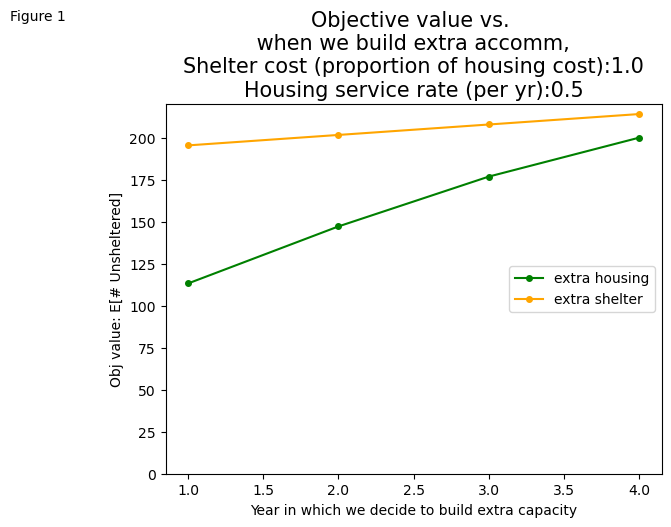

In [6]:
title1 = 'Shelter cost (proportion of housing cost):'
title2 = 'Housing service rate (per yr):'
x = [1,2,3,4]
n_rw = 1
n_cl = 1
plt.plot(x, housing_imprv1, color = 'green', label = 'extra housing', marker='o', markersize = 4)
plt.plot(x, shelter_imprv1, color = 'orange', label = 'extra shelter', marker='o', markersize = 4)
plt.title('Objective value vs. \n when we build extra accomm, \n' + 
          title1 + 
          str(round(12/s,2)) + 
          '\n' + 
          title2 + 
          str(round(1/service_times[0],2)),fontsize = 15)
plt.xlabel('Year in which we decide to build extra capacity')
plt.ylabel('Obj value: E[# Unsheltered]')
plt.ylim(0,220)
plt.text(0, 270, 'Figure 1', ha='center')
plt.legend(loc = 'center right')
plt.show()

Figure 1 above illustrates some of the basic characteristics of our solution space, given this current set up.

* **Takeaway 1**: whether we decide to build extra shelter or housing, our objective value gets worse (i.e. increases) the later we decide to use this budget. 

* **Takeaway 2**: when the cost of shelter is the same as that of housing, we will always prefer to build housing (assuming a positive housing service rate). 

This last point can be simply explained by looking at where the differences in the benefit of building extra shelter / housing come from. Let $o_{\text{s}}$ be the objective value associated with extra shelter being built at some point in time. We can break this down as: 

$o_{\text{s}} = o_{\text{baseline}} - i_{60} - i_{\text{more-shelter}}$

where $o_{\text{baseline}}$ is the objective value associated with not building extra accommodation, $i_{60}$ is the non-negative improvement in the objective value due to the first 60 extra shelters which are built and $i_{\text{more-shelter}}$ is the non-negative improvement due to the additional extra shelters which we can build with our budget if shelter is cheaper than housing. Both $i_{60}$ and $i_{\text{more-shelter}}$ are improvements as a direct result of people not being in the unsheltered queue because there is an extra sheltered place for them to be in. In the above chart, $i_{\text{more-shelter}} = 0$ since shelter is the same price as housing.

Now, we let $o_{\text{h}}$ be the objective value associated with extra housing being built at the same point in time as above. Similarly to $o_{\text{s}}$, we can break $o_{\text{h}}$ down as:

$o_{\text{h}} = o_{\text{baseline}} - i_{60} - i_{\text{increased-svc-rate}}$.

Note that the improvement in the objective function here is a result of extra people being able to leave the unsheltered queue and proceed to shelter ($i_{60}$), because space is made by people leaving the sheltered queue and entering available housing), and a result of an increased rate of people leaving the system when there are more housing servers ($i_{\text{increased-svc-rate}}$, which is positive if the housing service rate is positive). The former ($i_{60}$) is the same benefit which we get if we open 60 shelters which, remember, do not actually serve customers.

Our preference between building extra housing and shelter is determined by the difference $o_{\text{diff}}$ between $o_{\text{s}}$ and $o_{\text{h}}$: 

$o_{\text{diff}} = o_{\text{s}} - o_{\text{h}} =  - i_{\text{more-shelter}} + i_{\text{increased-svc-rate}}$

which can be visualised by the gap between the yellow and green lines in Figure 1. If $o_{\text{diff}} > 0$ then we prefer to add extra housing, if $o_{\text{diff}} < 0$ then we prefer shelter, and if $o_{\text{diff}} = 0$ then we are indifferent. 

We can now explain **takeaway 2** above: when shelter is the same price as housing, for each year from 1 to 4, $i_{\text{more-shelter}} = 0$ since we do not get more than 60 shelters with our budget, $i_{\text{increased-svc-rate}} > 0$ so $o_{\text{diff}} > 0$ and we prefer housing in each year.

It is interesting to see from Figure 2 than $|o_{\text{diff}}|$ gets smaller if we decide to use our budget later which indicates that for this problem set up, $i_{\text{increased-svc-rate}}$ gets worse more quickly as we postpone the building, compared to $i_{\text{more-shelter}}$. 

*Decreasing the cost of shelter*

Now we keep the housing service rate at 0.5 and decrease the cost of shelter. Decreasing the cost of shelter does not make a difference to the objective values when we have decided to build housing, but as we decrease the cost of shelter, the objective values associated with building extra shelter decrease, as shown in Figure 2 below: 

In [ ]:
# Explore range of shelter costs and service time distributions
# print('start at time ' + str(datetime.datetime.now()))

b = 12 # baseline amount of house builds
hx = 60 # baseline extra house units
s = 12 # baseline amount of shelters to add you can get for the price of 12 housing

yrs_dec = 4 # decision space years

additional_shelter = [hx + 6*i for i in [0,5,10,15,20,25]]
service_times = [2]

housing_imprv_all2_obj1 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all2_obj1 = [[] for i in range(len(additional_shelter))]

for i in range(len(additional_shelter)):
    sx = additional_shelter[i]
    for j in range(len(service_times)):
        sols = [{'housing': [b+hx, b, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b+hx, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b+hx, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b, b+hx], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s+sx, s, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s+sx, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s+sx, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s, s+sx]}]
        # expand solution space
        sols = [{'housing' : sols[k]['housing']+[b for l in range(data_as_is_exp2['analysis_horizon'] - yrs_dec)],
                 'shelter' : sols[k]['shelter']+[s for l in range(data_as_is_exp2['analysis_horizon'] - yrs_dec)]} for k in range(len(sols))]
        spc = rs.SolutionSpace(sols)
        spc.model_analytically(data_as_is_exp2, data_as_is_analytical, data_as_is_exp2['analysis_horizon'], float(service_times[j]))
        
        housing_imprv1 = []
        shelter_imprv1 = []

        for k in range(yrs_dec):
            imprv = spc.true_outputs_unsh[k]
            housing_imprv1.append(imprv)
            imprv = spc.true_outputs_unsh[k+4]
            shelter_imprv1.append(imprv)

        housing_imprv_all2_obj1[i].append(housing_imprv1)
        shelter_imprv_all2_obj1[i].append(shelter_imprv1)

#        print('done (' + str(i) + ', ' + str(j) + ')' + ' at time ' + str(datetime.datetime.now()))

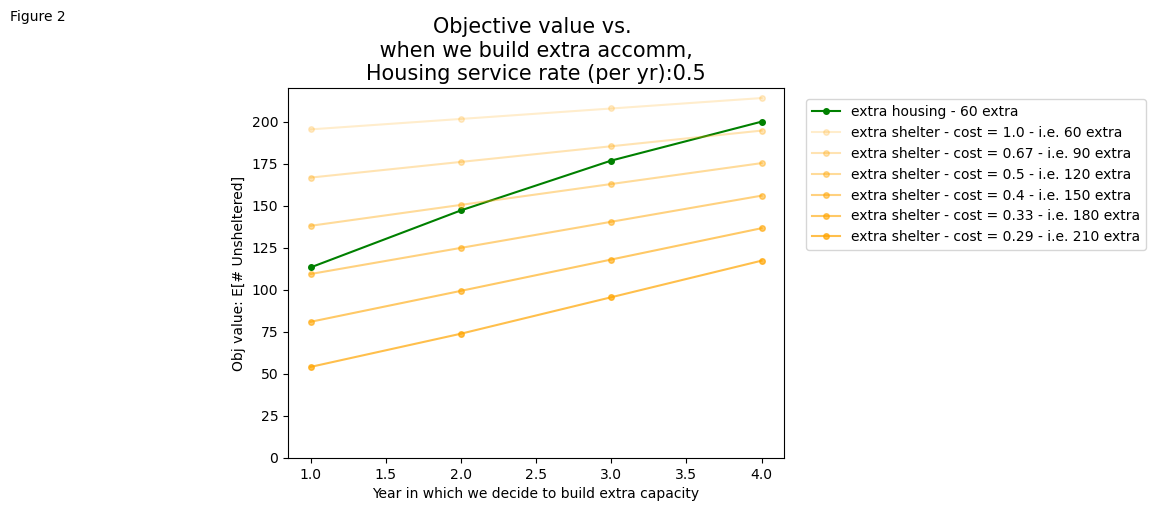

In [8]:
title2 = 'Housing service rate (per yr):'
x = [1,2,3,4]
fig, axs = plt.subplots()
axs.plot(x, housing_imprv_all2_obj1[0][0], color = 'green', label = 'extra housing - 60 extra', marker='o', markersize = 4)
for i in range(len(additional_shelter)):
    axs.plot(x, shelter_imprv_all2_obj1[i][0], color = 'orange', label = 'extra shelter - cost = ' + str(round(hx/(additional_shelter[i]),2)) + ' - i.e. ' + str(additional_shelter[i]) +  ' extra', marker='o', markersize = 4, alpha = (0.2 + i*0.1))
axs.set_ylim(0,220)
fig.legend(bbox_to_anchor=(1.2,0.7), loc = 'center')
plt.xlabel('Year in which we decide to build extra capacity')
plt.ylabel('Obj value: E[# Unsheltered]')
plt.title('Objective value vs. \n when we build extra accomm, \n' + 
          title2 + 
          str(round(1/service_times[0],2)),fontsize = 15)
axs.text(-1, 260, 'Figure 2')
plt.show()

As Figure 2 illustrates, as we decrease the cost of shelter, we start to have a preference for building extra shelter over extra housing. This change in preference can be summarised as follows: 

* **Takeaway 3**: As we reduce the cost of shelter, we move towards a preference for spending our extra budget on shelter, initially at later points in time, but eventually also in earlier points in time. 

Previous experimentation (see notebook 04_analytical_model_simple_experiment) has shown that as the housing rate increases, the shelter-cost at which the change in preference takes places becomes smaller (i.e. we need shelter to be cheaper to make it preferable to housing units when they service customers faster). 

*Increasing the service rate at housing*

We can use basic intuition about the model to state a fourth takeaway. If we reduce the housing rate enough, then extra houses effectively act in the same manner to extra shelter - i.e. they do not increase the rate of people leaving the system, and only help in that they take people out of the unsheltered queue. Along these lines, we can say: 

* **Takeaway 4**: when the service rate of housing units is close enough to zero, we will always prefer to build shelter (assuming shelter is cheaper than housing).

If we increase the service rate at housing, then our preference will start to change towards prefering housing. We show this below with a shelter cost of 0.5. We slowly increase our housing rate, observing the change in preference. The results are shown in Figure 3 below: 

In [ ]:
# Explore range of shelter costs and service time distributions
#print('start at time ' + str(datetime.datetime.now()))

b = 12 # baseline amount of house builds
hx = 60 # baseline extra house units
s = 12 # baseline amount of shelters to add you can get for the price of 12 housing

yrs_dec = 4 # decision space years

additional_shelter = [hx + 60]
service_times = [1/0.35, 1/0.4, 1/0.45, 1/0.5, 1/0.55, 1/0.6, 1/0.65]

housing_imprv_all3_obj1 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all3_obj1 = [[] for i in range(len(additional_shelter))]

for i in range(len(additional_shelter)):
    sx = additional_shelter[i]
    for j in range(len(service_times)):
        sols = [{'housing': [b+hx, b, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b+hx, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b+hx, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b, b+hx], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s+sx, s, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s+sx, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s+sx, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s, s+sx]}]
        # expand solution space
        sols = [{'housing' : sols[k]['housing']+[b for l in range(data_as_is_exp2['analysis_horizon'] - yrs_dec)],
                 'shelter' : sols[k]['shelter']+[s for l in range(data_as_is_exp2['analysis_horizon'] - yrs_dec)]} for k in range(len(sols))]
        spc = rs.SolutionSpace(sols)
        spc.model_analytically(data_as_is_exp2, data_as_is_analytical, data_as_is_exp2['analysis_horizon'], float(service_times[j]))
        
        housing_imprv1 = []
        shelter_imprv1 = []

        for k in range(yrs_dec):
            imprv = spc.true_outputs_unsh[k]
            housing_imprv1.append(imprv)
            imprv = spc.true_outputs_unsh[k+4]
            shelter_imprv1.append(imprv)

        housing_imprv_all3_obj1[i].append(housing_imprv1)
        shelter_imprv_all3_obj1[i].append(shelter_imprv1)

#        print('done (' + str(i) + ', ' + str(j) + ')' + ' at time ' + str(datetime.datetime.now()))

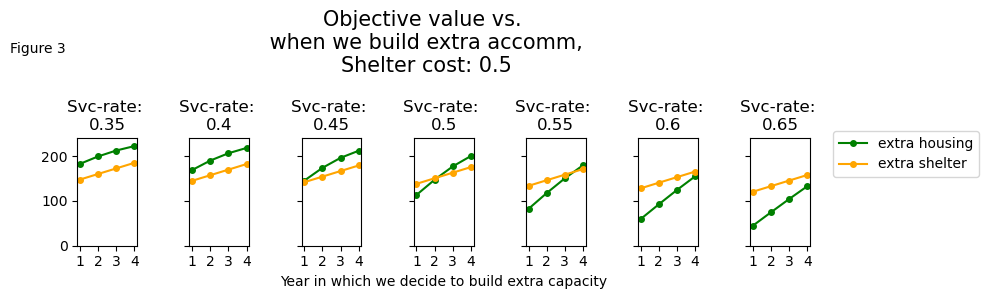

In [10]:
title = 'Svc-rate: '
title2 = 'Shelter cost: '
x = [1,2,3,4]
n_cl = len(service_times)
n_rw = 1
fig, axs = plt.subplots(n_rw, n_cl, figsize=(8, 3), sharex=True)
for j in range(n_cl):
    line1, = axs[j].plot(x, housing_imprv_all3_obj1[0][j], color = 'green', label = 'extra housing', marker='o', markersize = 4)
    line2, = axs[j].plot(x, shelter_imprv_all3_obj1[0][j], color = 'orange', label = 'extra shelter', marker='o', markersize = 4)
    axs[j].set_title(title + '\n' + str(round(1/service_times[j],2)))
    axs[j].set_ylim(0,240)
    if j == 3:
        axs[j].set_xlabel("Year in which we decide to build extra capacity", loc = 'center')

plt.suptitle('Objective value vs. \n when we build extra accomm, \n' + title2 + 
             str(round(hx/additional_shelter[0],2)),fontsize = 15)
fig.legend(handles=[line1, line2], bbox_to_anchor=(1.1,0.5), loc = 'center') 
fig.tight_layout()

plt.text(-40, 430, 'Figure 3')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
#plt.xlabel("Year in which we decide to build extra capacity", loc = 'right')
plt.ylabel("Obj value: E[# Unsheltered]")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

As Figure 3 illustrates, as we increase the service rate at housing, we start to have a preference for building extra housing over extra shelter. We can summarise this change in preference as follows: 

* **Takeaway 5**: As we increase the service rate at housing, we move towards a preference for spending our extra budget on housing, initially at earlier points in time, but eventually also in later points in time. 

Previous experimentation (see notebook 04_analytical_model_simple_experiment) has shown that as the cost of shelter decreases, the housing service rate at which the change in preference takes places becomes higher (i.e. we need housing units to serve customers faster to make that preferable to shelter units when they get cheaper). 

*Studing how 'quickly' we lose the benefits of extra shelter and extra housing, if we delay building*

It has been interesting to observe from takeaway 3 that as we reduce the cost of shelter, our preference for housing over shelter is initially maintained at earlier points in time, but lost at later points in time. Also, from takeaway 5 we see that as we increase the housing service rate, our preference for housing over shelter comes initially only at earlier points in time.

This suggests, in a crude sense, that we are 'more likely' to prefer housing at earlier points in time than later points in time. The improvement that we get in our objective value from building housing ($i_{\text{increased-svc-rate}}$ in our discussion above) dies off more quickly than the improvement that we get from building shelter ($i_{\text{more-shelter}}$ in our discussion above). 

This point can be explored further by considering a case where the objective values of building housing and of building shelter in year 1 are roughly the same. This is the case with a shelter cost of 0.4 and a housing service rate of 0.5. Figure 4 below illustrates how the objective values then change if we decide to build housing or shelter at a later point in time: 

In [ ]:
# Explore range of shelter costs and service time distributions
# print('start at time ' + str(datetime.datetime.now()))

b = 12 # baseline amount of house builds
hx = 60 # baseline extra house units
s = 12 # baseline amount of shelters to add you can get for the price of 12 housing

yrs_dec = 4 # decision space years

additional_shelter = [hx + 90]
service_times = [2]

housing_imprv_all4_obj1 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all4_obj1 = [[] for i in range(len(additional_shelter))]

for i in range(len(additional_shelter)):
    sx = additional_shelter[i]
    for j in range(len(service_times)):
        sols = [{'housing': [b+hx, b, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b+hx, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b+hx, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b, b+hx], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s+sx, s, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s+sx, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s+sx, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s, s+sx]}]
        # expand solution space
        sols = [{'housing' : sols[k]['housing']+[b for l in range(data_as_is_exp2['analysis_horizon'] - yrs_dec)],
                 'shelter' : sols[k]['shelter']+[s for l in range(data_as_is_exp2['analysis_horizon'] - yrs_dec)]} for k in range(len(sols))]
        spc = rs.SolutionSpace(sols)
        spc.model_analytically(data_as_is_exp2, data_as_is_analytical, data_as_is_exp2['analysis_horizon'], float(service_times[j]))
        
        housing_imprv1 = []
        shelter_imprv1 = []

        for k in range(yrs_dec):
            imprv = spc.true_outputs_unsh[k]
            housing_imprv1.append(imprv)
            imprv = spc.true_outputs_unsh[k+4]
            shelter_imprv1.append(imprv)

        housing_imprv_all4_obj1[i].append(housing_imprv1)
        shelter_imprv_all4_obj1[i].append(shelter_imprv1)

#        print('done (' + str(i) + ', ' + str(j) + ')' + ' at time ' + str(datetime.datetime.now()))

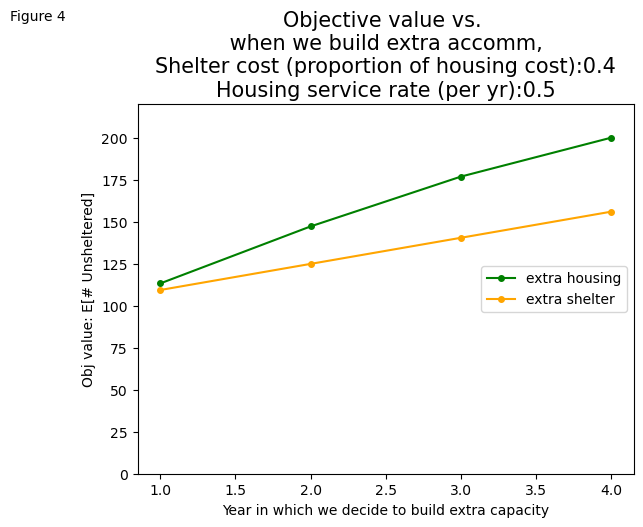

In [12]:
title1 = 'Shelter cost (proportion of housing cost):'
title2 = 'Housing service rate (per yr):'
x = [1,2,3,4]
n_rw = 1
n_cl = 1
plt.plot(x, housing_imprv_all4_obj1[0][0], color = 'green', label = 'extra housing', marker='o', markersize = 4)
plt.plot(x, shelter_imprv_all4_obj1[0][0], color = 'orange', label = 'extra shelter', marker='o', markersize = 4)
plt.title('Objective value vs. \n when we build extra accomm, \n' + 
          title1 + 
          str(round(hx/additional_shelter[0],2)) + 
          '\n' + 
          title2 + 
          str(round(1/service_times[0],2)),fontsize = 15)
plt.xlabel('Year in which we decide to build extra capacity')
plt.ylabel('Obj value: E[# Unsheltered]')
plt.ylim(0,220)
plt.text(0, 270, 'Figure 4')
plt.legend(loc = 'center right')
plt.show()

Figure 4 above illustrates that given the model parameters which lead to roughly equal objective values for building extra shelter and building extra housing in year 1, if we wait to build in later years, the objective value associated with building extra housing gets worse more quickly than that associated with building extra shelter. We can summarise this with the following takeaway: 

* **Takeaway 6**: If we wait to build our extra accommodation at a later point in time, the benefit of building extra housing is lost more quickly than the benefit of building extra shelter, provided they start with roughly the same benefits. 

Previous experimentation (see notebook 04_analytical_model_simple_experiment) has shown that the same conclusion holds when housing starts off with greater benefit than shelter, but if shelter is much more preferable to housing initially, its benefit can be lost more quickly than the corresponding benefit of housing. 

Previous experimentation (see notebook 04_analytical_model_simple_experiment) has also shown graphically that for a wide range of housing service rates and costs of shelter, the second derivative (of the obj value w.r.t. the year in which we decide to build) appears to be consistently negative for housing and consistently lower than shelter, provided the queues are not very small.